# **SAAD AHMED | BCS 6D | 22k-4345**

In [ ]:
corpus = """Deep learning is amazing. Machine learning is powerful. AI is the future. Data science is the new frontier.
Computers can learn from data. Data is crucial for AI."""

with open("text_corpus.txt", "w") as file:
    file.write(corpus)

print("Text corpus created successfully.")


Text corpus created successfully.


In [ ]:
!pip install nltk --quiet

# **TASK 1**

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

with open("text_corpus.txt", "r") as file:
    text = file.read().lower()

text = text.translate(str.maketrans('', '', string.punctuation))

tokens = text.split()

stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

vocab = sorted(set(tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print("✅ Preprocessing complete!")
print("Vocabulary Size:", len(vocab))
print("Sample Tokens:", tokens[:10])


✅ Preprocessing complete!
Vocabulary Size: 14
Sample Tokens: ['deep', 'learning', 'amazing', 'machine', 'learning', 'powerful', 'ai', 'future', 'data', 'science']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **TASK 2**

In [ ]:
window_size = 2
skip_gram_pairs = []

for i, target_word in enumerate(tokens):
    target_idx = word2idx[target_word]

    for j in range(i - window_size, i + window_size + 1):
        if j != i and j >= 0 and j < len(tokens):
            context_word = tokens[j]
            context_idx = word2idx[context_word]
            skip_gram_pairs.append((target_idx, context_idx))

print("Total training pairs:", len(skip_gram_pairs))
print("Example pairs (word-level):")
for i in range(5):
    t, c = skip_gram_pairs[i]
    print(f"({idx2word[t]}, {idx2word[c]})")


Total training pairs: 66
Example pairs (word-level):
(deep, learning)
(deep, amazing)
(learning, deep)
(learning, amazing)
(learning, machine)


# **TASK 3**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_word):
        emb = self.embeddings(input_word)
        out = self.output(emb)
        return out

embedding_dim =  10
vocab_size = len(vocab)
model = SkipGramModel(vocab_size,embedding_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("Model defined and ready to train!")


Model defined and ready to train!


# **TASK 4**

In [ ]:
inputs, targets = zip(*skip_gram_pairs)
inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    #loss after every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training is complte!")

torch.save(model.embeddings.weight.data, "word_embeddings.pth")
print("Word embeddings iz saved!")


Epoch [50/500], Loss: 1.7290
Epoch [100/500], Loss: 1.4630
Epoch [150/500], Loss: 1.4325
Epoch [200/500], Loss: 1.4253
Epoch [250/500], Loss: 1.4223
Epoch [300/500], Loss: 1.4207
Epoch [350/500], Loss: 1.4198
Epoch [400/500], Loss: 1.4192
Epoch [450/500], Loss: 1.4188
Epoch [500/500], Loss: 1.4185
Training is complte!
Word embeddings iz saved!


In [ ]:
!pip install matplotlib scikit-learn --quiet

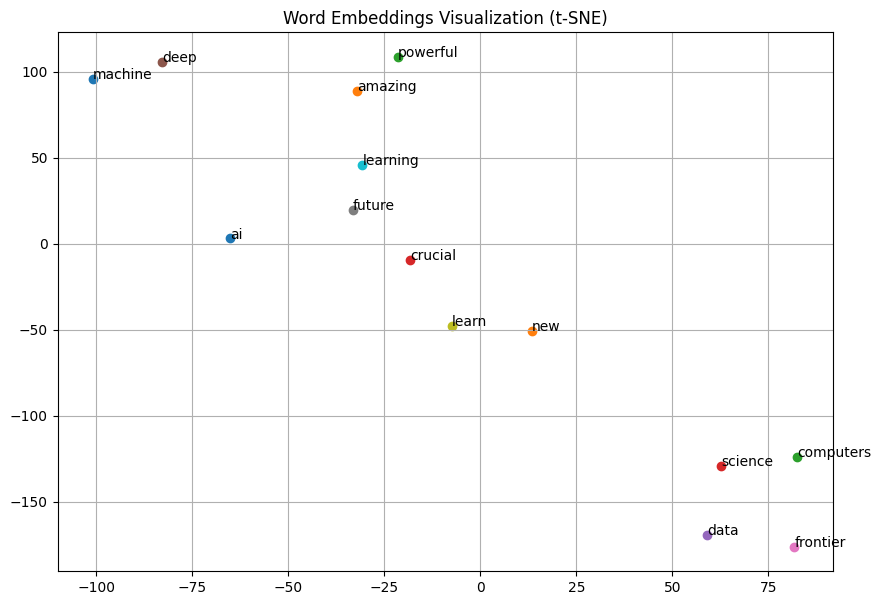

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embeddings = model.embeddings.weight.data.cpu().numpy()

tsne = TSNE(n_components=2,random_state=42, perplexity=3)
embeddings_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(10, 7))
for idx, word in idx2word.items():
    x, y = embeddings_2d[idx]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=10)

plt.title("Word Embeddings Visualization (t-SNE)")
plt.grid(True)
plt.show()


# **TASK 5**

In [ ]:
window_size = 2
cbow_pairs = []

for i in range(window_size, len(tokens) - window_size):
    context = []
    for j in range(i - window_size, i + window_size + 1):
        if j != i:
            context.append(word2idx[tokens[j]])
    target = word2idx[tokens[i]]
    cbow_pairs.append((context, target))

print("✅ CBOW training pairs:",len(cbow_pairs))
print("Example (context indexes -> target index):")
for i in range(3):
    print(cbow_pairs[i])


✅ CBOW training pairs: 14
Example (context indexes -> target index):
([5, 9, 10, 9], 1)
([9, 1, 9, 12], 10)
([1, 10, 12, 0], 9)


In [ ]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_words):
        embeds = self.embeddings(context_words)
        combined = embeds.mean(dim=1)
        out = self.linear(combined)
        return out

cbow_model = CBOWModel(vocab_size, embedding_dim)
cbow_criterion = nn.CrossEntropyLoss()
cbow_optimizer = optim.Adam(cbow_model.parameters(), lr=0.01)


In [ ]:
for epoch in range(300):
    total_loss = 0
    for context, target in cbow_pairs:
        context_tensor = torch.tensor([context], dtype=torch.long)
        target_tensor = torch.tensor([target], dtype=torch.long)
        cbow_optimizer.zero_grad()
        output = cbow_model(context_tensor)

        loss = cbow_criterion(output, target_tensor)
        loss.backward()
        cbow_optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/300], Loss: {total_loss:.4f}")

print("CBOW Training Complete!")


Epoch [50/300], Loss: 0.6678
Epoch [100/300], Loss: 0.1351
Epoch [150/300], Loss: 0.0530
Epoch [200/300], Loss: 0.0263
Epoch [250/300], Loss: 0.0146
Epoch [300/300], Loss: 0.0087
CBOW Training Complete!


In [ ]:
def get_embedding(word, model):
    word_idx = word2idx[word]
    return model.embeddings(torch.tensor(word_idx)).detach()

def find_analogy(word_a, word_b, word_c, model):
    emb_a= get_embedding(word_a, model)
    emb_b= get_embedding(word_b, model)
    emb_c= get_embedding(word_c, model)
    target_vec = emb_b - emb_a + emb_c
    similarities=[]

    for idx in range(vocab_size):
        word_vec = model.embeddings(torch.tensor(idx)).detach()
        cos_sim = torch.cosine_similarity(target_vec, word_vec, dim=0)
        similarities.append((idx2word[idx], cos_sim.item()))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:5]

print("Analogy Test: learning - deep + machine ≈ ?")
results = find_analogy("deep", "learning", "machine", cbow_model)
for word, score in results:
    print(f"{word}: {score:.4f}")


Analogy Test: learning - deep + machine ≈ ?
machine: 0.7344
learning: 0.6160
amazing: 0.5790
powerful: 0.3113
learn: 0.1934
